# Anomaly Detection in Network Traffic

Some attacks attempt to flood a computer with network traffic. In some other cases, attacks attempt to exploit flaws in networking software in order to gain unauthorized access to a computer. Detecting an exploit in an incredibly large haystack of network requests is not easy.

Some exploit behaviors follow known patterns such as scanning every port in a short of time, sending a burst of request to a port... However, the biggest threat may be the one that has never been detected and classified yet. Part of detecting potential network intrusions is detecting anomalies. These are connections that aren't known to be attacks, but, do not resemble connections that have been observed in the past.

In this notebook, K-means is used to detect anomalous network connections based on statistics about each of them.

Reference - https://github.com/alegaballo/AML

Dataset Download - http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn import datasets, cluster
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Dataset
The data comes from [KDD Cup 1999](http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html). The dataset is about 708MB and contains about 4.9M connections. For each connection, the data set contains information like the number of bytes sent, login attempts, TCP errors, and so on. Each connection is one line of CSV-formatted data, containing 38 features: back, buffer_overflow, ftp_write, guess_passwd, imap, ipsweep, land, loadmodule, multihop, neptune, nmap, normal, perl, phf, pod, portsweep, rootkit, satan, smurf, spy, teardrop, warezclient, warezmaster. For more details about each feature, please follow this [link](http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html).

Many features take on the value 0 or 1, indicating the presence or absence of a behavior such as `su_attempted` in the 15th column. Some features are counts, like `num_file_creations` in the 17th columns. Some others are the number of sent and received bytes.

## Clustering without using categorical features

In [3]:
import os
import sys
import re
from pyspark import SparkContext, SparkConf

conf = SparkConf().setAppName("app").setMaster("local[*]")
sc = SparkContext(conf=conf)

from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.sql.functions import *
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pyspark.sql.functions as func
import matplotlib.patches as mpatches
from pyspark.mllib.clustering import KMeans, KMeansModel
from operator import add
import seaborn as sns

# input_path = "datasets/kddcup.data.corrected"
input_path = "datasets/kddcup.data_10_percent_corrected"
raw_data = sc.textFile(input_path, 12)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/01/12 12:00:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


There are two types of features: numerical features and categorical features.
Currently, to get familiar with the data and the problem, we only use numerical features. In our data, we also have pre-defined groups for each connection, which we can use later as our "ground truth" for verifying our results.

In general, since clustering is un-supervised, you don't have access to ground truth. For this reason, several metrics to judge the quality of clustering have been devised. For a short overview of such metrics, follow this [link](https://en.wikipedia.org/wiki/Cluster_analysis#Internal_evaluation). Note that computing such metrics, that is trying to assess the quality of your clustering results, is as computationally intensive as computing the clustering itself!

Function `parseLine` to construct a tuple of `(label, vector)` for each connection, extract the data that contains only the data points (without label), then print the number of connections.

* `label` is the pre-defined label of each connection
* `vector` is a numpy array that contains values of all features, but the label and the categorial features at index `1,2,3` of each connection. Each `vector` is a data point.

In [4]:
def parseLine(line):
    cols = line.split(",")
    # label is the last column
    label = cols[-1]
    
    # vector is every column, except the label
    vector = cols[:-1]
    
    # delete values of columns that have index 1->3 (categorical features)
    vector = [x for i, x in enumerate(vector) if i not in [1, 2, 3]]
    
    # convert each value from string to float
    vector = np.array(vector, dtype=np.float)
    
    return (label, vector)

labelsAndData = raw_data.map(parseLine).cache()

# we only need the data, not the label
data = labelsAndData.map(lambda x : x[1]).cache()

# number of connections
n = data.count()

/var/folders/yf/tn88zczj6719nsbh9hywpw440000gn/T/ipykernel_36783/1097150223.py:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/var/folders/yf/tn88zczj6719nsbh9hywpw440000gn/T/ipykernel_36783/1097150223.py:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/var/folders/yf/tn88zczj6719nsbh9hywpw440000gn/T/ipykernel_36783/1097150223.py:13: Dep

In [5]:
print("Number of connections:", n)
print("Details per connection:", len(data.first()))

Number of connections: 494021


Details per connection: 38


24/01/12 12:01:15 WARN BlockManager: Task 12 already completed, not releasing lock for rdd_3_0


In [6]:
x = labelsAndData.map(lambda x: x[0]).distinct().count()
print("Total number of labels:\n", x)
y = labelsAndData.map(lambda x : (x[0], 1)).reduceByKey(add).collect()
#print("The labels available and their occurrence in the dataset is:\n")
#for _ in y:
#    print("%20s\t%d" %(_[0], _[1]))

Total number of labels:
 23


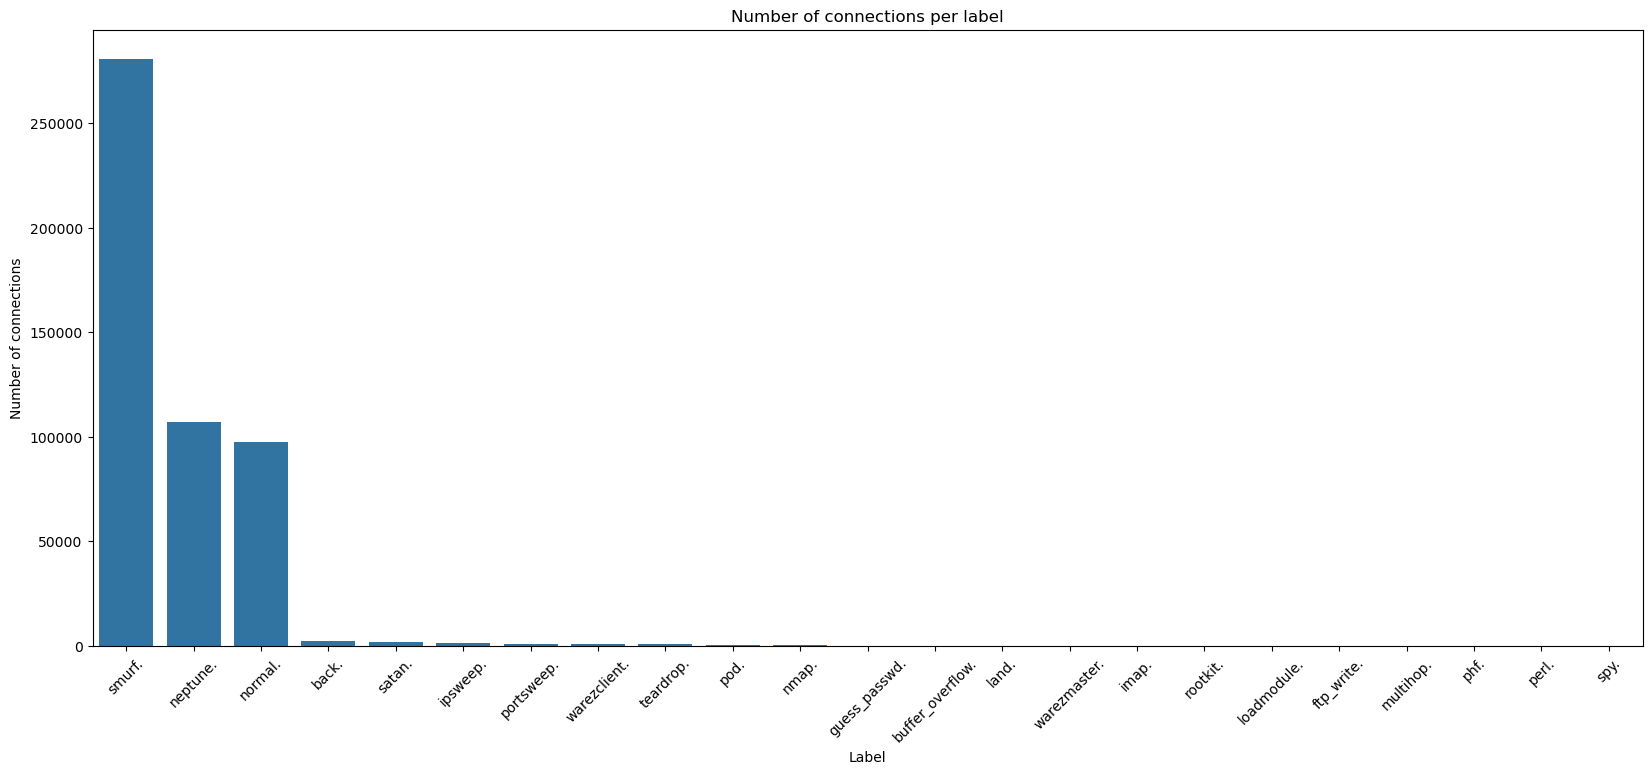

In [7]:
y.sort(key=lambda x : x[1], reverse=True)
plt.figure(figsize=(20,8))
sns.barplot(x=np.arange(len(y)), y=[_[1] for _ in y])
plt.xticks(np.arange(len(y)), [_[0] for _ in y], rotation=45)
plt.xlabel("Label")
plt.ylabel("Number of connections")
plt.title("Number of connections per label")
plt.show()

In [8]:
#amount of connections of the first 3 labels.
print("amount of connections of the first 3 labels:\t", y[0][1]+y[1][1]+y[2][1])

amount of connections of the first 3 labels:	 485269


There are 23 different labels but actually we can immediately see that the data is not equally divided.
<br><br>
Of the nearly 5 million connections, more than a half are labelled as <i>smurf</i> and other 2 millions are equally divided as <i>neptune</i> and <i>normal</i>. We computed above the amount of connections that this first 3 labels amount for.
<br>
As we can see, of the 4898431, 4852684 are dedicated to just 3 labels leaving less than 40 thousand connections to the remaining 20 labels.
<br><br>
This initial look inside the data may hint us on how the data is divided in the space: since so much data has the same label, probably it will be packed up together and leave all the other labels as "outliers".


<div class="alert alert-warning">
<h3>Principal Component Analysis</h3>
</div>

In [9]:
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.feature import PCA as PCAmllib

vectorData = data.map(Vectors.dense)
PCAModel3 = PCAmllib(3).fit(vectorData)
pcaData3 = PCAModel3.transform(vectorData).sample(withReplacement=False, fraction=0.01).collect()

PCAModel2 = PCAmllib(2).fit(vectorData)
pcaData2 = PCAModel2.transform(vectorData).sample(withReplacement=False, fraction=0.01).collect()

24/01/12 12:01:24 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 6 (TID 61): Attempting to kill Python Worker
24/01/12 12:01:29 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 7 (TID 62): Attempting to kill Python Worker
24/01/12 12:01:38 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 10 (TID 78): Attempting to kill Python Worker
24/01/12 12:01:42 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/01/12 12:01:45 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK
24/01/12 12:01:54 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 14 (TID 106): Attempting to kill Python Worker
24/01/12 12:01:58 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 15 (TID 107): Attempting to kill Python Worker
24/01/12 12:02:04 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 18 (TID 123)

<Figure size 800x800 with 0 Axes>

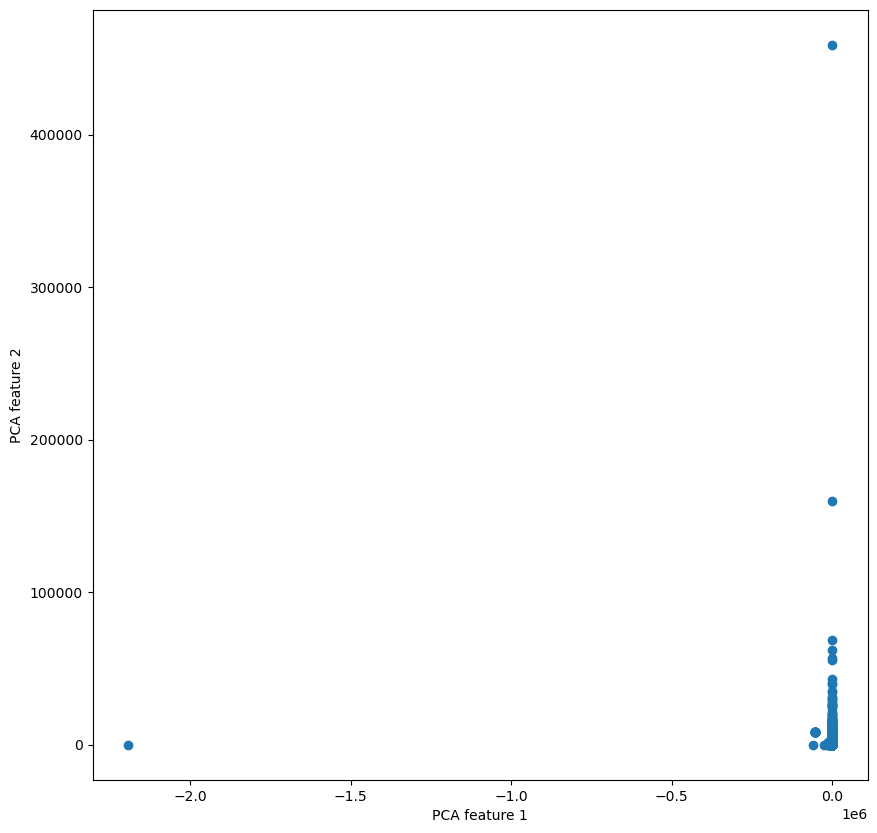

In [31]:
#pca plot
fig = plt.figure(1, figsize=(8, 8))
ax = Axes3D(fig)

ax.scatter([x[0] for x in pcaData3], [x[1] for x in pcaData3], [x[2] for x in pcaData3])

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('PCA feature 1')
ax.set_ylabel('PCA feature 2')
ax.set_zlabel('PCA feature 3')
plt.show()

fig = plt.figure(1, figsize=(10, 10))

plt.scatter([x[0] for x in pcaData2], [x[1] for x in pcaData2])

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
plt.xlabel('PCA feature 1')
plt.ylabel('PCA feature 2')

plt.show()

<div class="alert alert-success">
Above are the plots of the Principal Component Analysis did with k=3 and k=2.
<br><br>
First of all, <b>what is PCA?</b> It is a procedure to transform a set of variables, possibly correlated, into another set of uncorrelated variables called principal components. The number of principal components is less or equal to the number of initial variables and this technique is really useful when we want to reduce dimensionality. If we start for example with 38 dimensions, after the transformation we get a set of principal components and, according to the number of dimensions we want, we get the first k principal components. And why do we get the first and not random ones? Because the transformation is defined in such a way that the principal components are ordered with respect to how much variability of the data they account for.
<br><br>
Looking at the first plot, the one where we used 3 principal components, we can see that the majority of the data is packed up at the intersection of the 3 axis and that the data lies especially on the z-axis. This means that, even though we used 3 principal components, 2 of them don't have really high variance and in fact they don't show too much data.
<br><br>
The same happens for the second plot where we use just two components, and the data is still packed together in $(0,0)$ (in the next plots we'll try to zoom in).
<br><br>
But why all the data is perpendicular to each other?
<br>
Because, looking at the plot of the data (not with PCA), we can see that the points are already almost all perpendicular to each other and so, given that the eigenvalues are uncorrelated (and so orthogonal to each other), when multiplied with the points themselves, they get projected on just one of the axis every time.
<br><br>
We used the PCA function in the <code>MLLib</code> library otherwise it would have been impossibile to compute it in the full dataset.<br>
Actually, when we initially tried to use PCA on a small sample of data and we managed to use the PCA function in the <code>sklearn</code> library, we had the possibility to understand the amount of variance with the <code>explained_variance_ratio</code> function and we discovered that with just two principal components, almost 100 percent of the information was represented. 
<br>
This is a proof of what we saw before analyzing the data: that since so much of the data is represented with just 3 labels, it will be all packed together.
<br><br>
Looking closer at the second plot, we see that the dimensions are huge and so let's try to zoom into $(0,0)$.
</div>

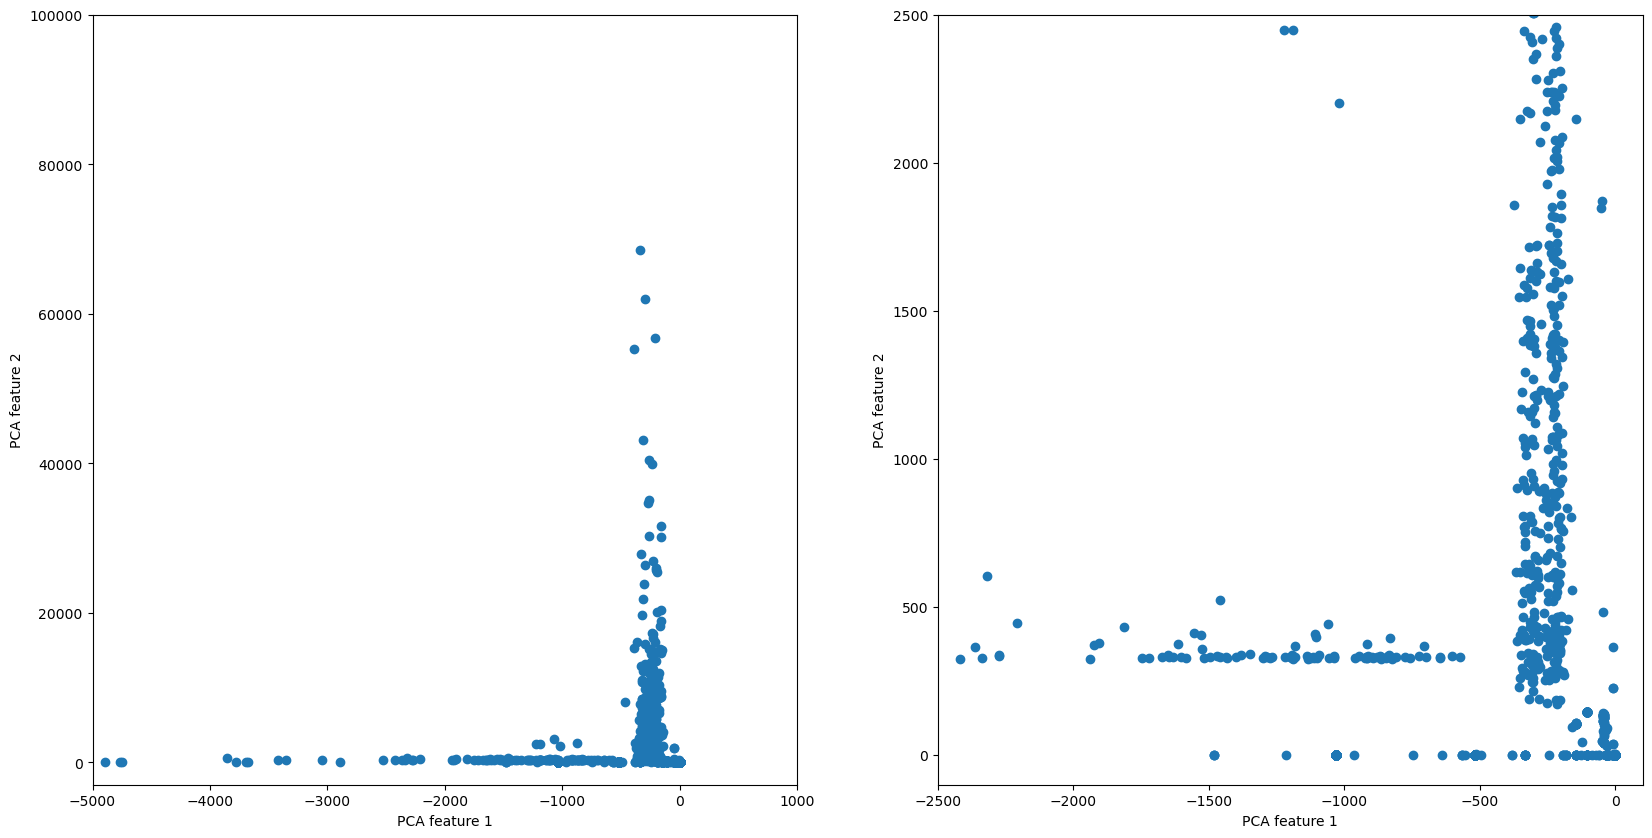

In [11]:
fig = plt.figure(1, figsize=(20, 10))
plt.subplot(121)
plt.scatter([x[0] for x in pcaData2], [x[1] for x in pcaData2])
plt.xlabel('PCA feature 1')
plt.ylabel('PCA feature 2')
plt.xlim(-5000,1000)
plt.ylim(-3000, 100000)

plt.subplot(122)
plt.scatter([x[0] for x in pcaData2], [x[1] for x in pcaData2])
plt.xlabel('PCA feature 1')
plt.ylabel('PCA feature 2')
plt.xlim(-2500,100)
plt.ylim(-100, 2500)
plt.show()

<div class="alert alert-success">
This plot shows better the effectiveness of the PCA. All of the data is compressed in the previous plot because there are some points with a much higher value in those dimensions that make all the data shrink together. Zooming in, we can see that the majority of the points span in a small contour of the dimensions.
</div>

<div class="alert alert-warning">
<h3>Choosing K </h3>
</div>

How many clusters are appropriate for a dataset? In particular, for our own dataset, it's clear that there are 23 distinct behavior patterns in the data, so it seems that k could be at least 23, or likely, even more. In other cases, we even don't have any information about the number of patterns at all (remember, generally your data is not labelled!). Our task now is finding a good value of $k$. For doing that, we have to build and evaluate models with different values of $k$. A clustering could be considered good if each data point were near to its closest centroid. One of the ways to evaluate a model is calculating the Mean of Squared Errors of all data points.

<div class="alert alert-info">
Calculate the MSE of each model that is corresponding to each value of $k$.  

</div>

In [12]:
# k: the number of clusters
def clusteringScore(data, k, withCenters=False):
    clusters = KMeans.train(data, k, maxIterations=10, initializationMode="random")
    # calculate mean square error
    if withCenters is True:
        return (clusters.computeCost(data), len(clusters.centers))
    return clusters.computeCost(data)

In [13]:
k_vector = [2,5,10,23,30,50,70,100,120,200,300,400]

scores = [clusteringScore(data, k, withCenters=True) for k in k_vector]
for i, score in enumerate(scores):
    print("k = %3d, (effective nr. of clusters = %3d) WSSSE = %d" %(k_vector[i], score[1], score[0]))

k =   2, (effective nr. of clusters =   1) WSSSE = 482987189361441024
k =   5, (effective nr. of clusters =   4) WSSSE = 239184430143624
k =  10, (effective nr. of clusters =   2) WSSSE = 2220633804525271
k =  23, (effective nr. of clusters =  13) WSSSE = 212951209240766
k =  30, (effective nr. of clusters =  19) WSSSE = 274192810723103
k =  50, (effective nr. of clusters =  30) WSSSE = 208240800589754
k =  70, (effective nr. of clusters =  37) WSSSE = 168079468894426
k = 100, (effective nr. of clusters =  52) WSSSE = 170383833783012
k = 120, (effective nr. of clusters =  63) WSSSE = 170397230615871
k = 200, (effective nr. of clusters =  88) WSSSE = 173854782313377
k = 300, (effective nr. of clusters = 142) WSSSE = 166578180378674
k = 400, (effective nr. of clusters = 180) WSSSE = 163101272157703


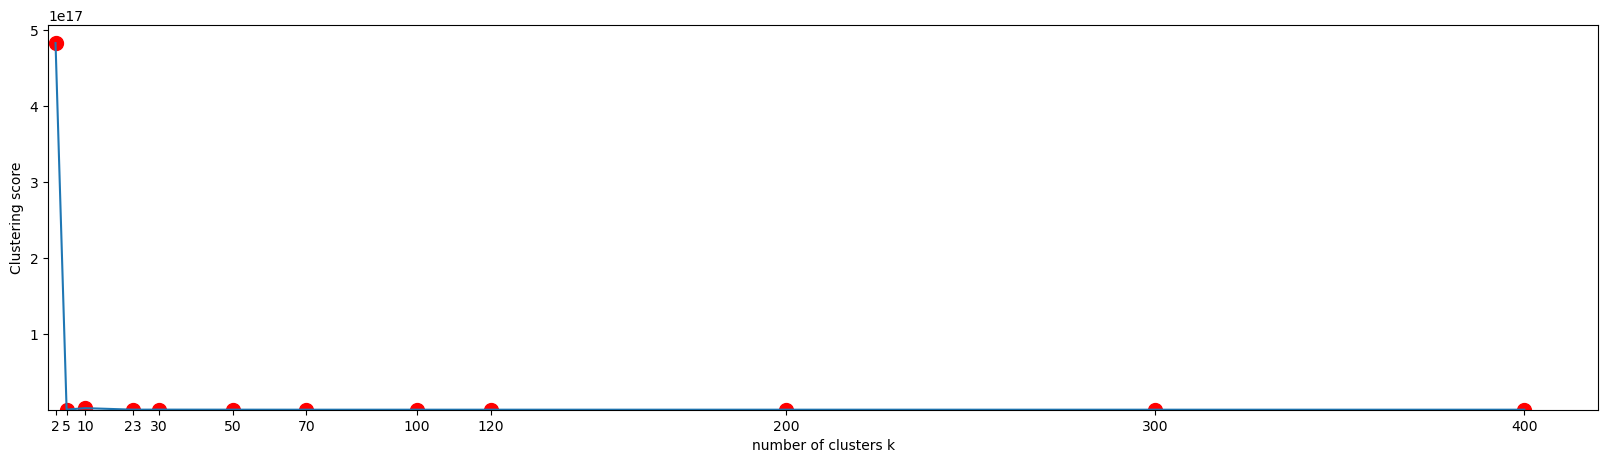

In [14]:
# plot results
plt.figure(figsize=(20,5))
_ = [_[0] for _ in scores]
plt.scatter(k_vector, _, color="r", s=100)
plt.plot(k_vector, _)
plt.axis([0, np.max(k_vector)*1.05, 0.85*np.min(_), 1.05*np.max(_)])
plt.xlabel("number of clusters k")
plt.ylabel("Clustering score")
plt.xticks(k_vector)
plt.show()

<div class="alert alert-success">
We tried a different increasing number of clusters and we plotted the results above.
<br>
As we can see from the plot and more importantly, as we know from the theory, increasing the number of clusters improves the clustering score. And this is quite obvious because if we put a huge number of clusters, for example the same as the number of points in the dataset, each point will be in its own cluster and the distance from the center will be zero. This is why simply increasing k to improve our clustering is not an efficient and sensible choice and we should find a compromise between number of clusters and clustering score.
<br><br>
The plot shows us that the initial choice of k=2 was absolutely nonsense being that the clustering score is really high with respect to the rest of the tests. Afterwards, with k=5, we have a huge drop when we test the KMeans. From k=23 onwards, the clustering score doesn't decrease anymore in a consistent way and so going further than 10/23 clusters doesn't seem to be a good choice.
<br><br>
This actually makes sense if we think about the data we are clustering: we have 23 different labels but actually many of them are pretty similiar and with similiar attributes and so when we use less clusters, they still stay packed together and increasing the clusters will just make more clusters really near to each other not improving the clustering score.
<br><br>
Other than simply looking at the plot, another more methodological solution could have been to apply the <a href="http://erikerlandson.github.io/blog/2016/08/03/x-medoids-using-minimum-description-length-to-identify-the-k-in-k-medoids/">Minimum Description Length Principle</a> that tries to find the best optimization for k.
</div>

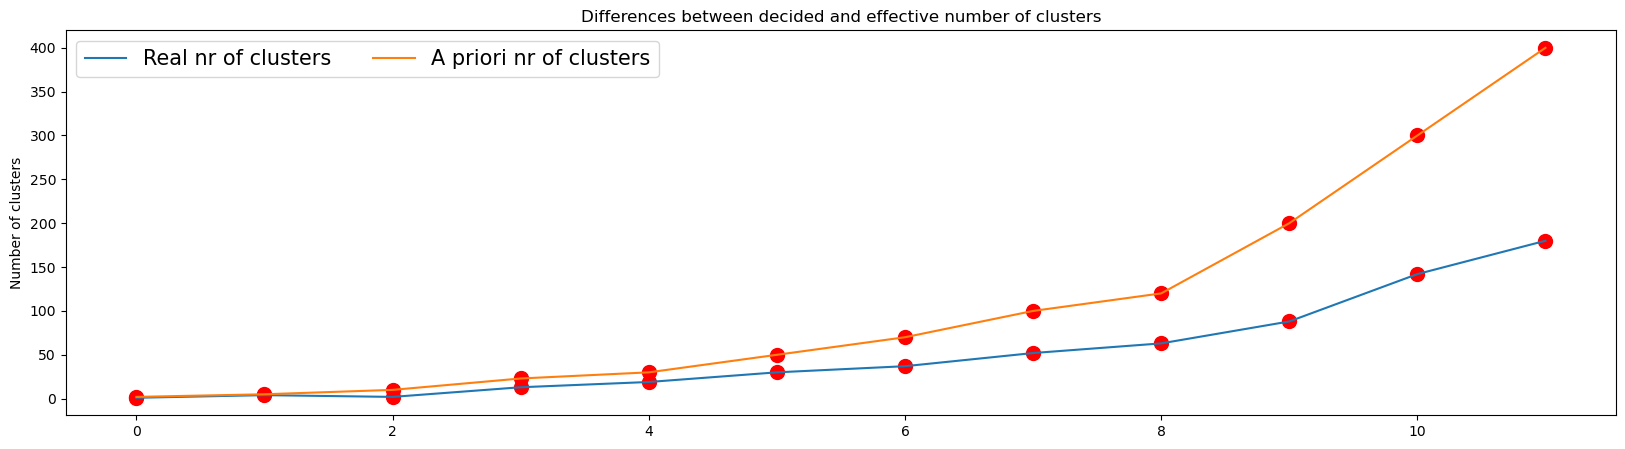

In [15]:
# plot results
plt.figure(figsize=(20,5))
_ = [_[1] for _ in scores]
plt.scatter(np.arange(len(k_vector)), _, c="r", s=100)
plt.scatter(np.arange(len(k_vector)), k_vector, c="r", s=100)
plt.plot(np.arange(len(k_vector)), _, label="Real nr of clusters")
plt.plot(np.arange(len(k_vector)), k_vector, label="A priori nr of clusters")
plt.ylabel("Number of clusters")
#plt.xticks(np.arange(len(k_vector)), k_vector)
plt.title("Differences between decided and effective number of clusters")
plt.legend(ncol=2, loc='upper left', frameon=True, fontsize=15)
#for i in np.arange(len(k_vector)):
#        plt.annotate(str(_[i]), i*0.98, _[i]*0.98)
#        plt.annotate(str(k_vector[i]), i*1.01, k_vector[i]*1.01)
plt.show()

<div class="alert alert-success">
We tried to go further in details on the previous plot and, knowing from theory that increasing the number of clusters usually improves the error, we were wondering why the clusteringScore stayed the same after a certain point.
<br><br>
In the plot above, we decided to plot the number of clusters per run, k, together with the effective number of clusters. <b><i>What do we mean with effective number of clusters?</i></b> When the kmeans algorithm runs, the various points change cluster as the centers get updated. If, after reassigning the points, one of the cluster becomes empty, it is deleted from the list of clusters.
<br><br>
As we can see from the plot above, when the number of clusters is small, none of them is deleted but, as we increase the number of clusters, the effective number of clusters doesn't increase with the same pace and this is why the clusteringScore doesn't improve a lot. The trend is that after 20 clusters, approximately half of the desired clusters gets deleted. We can see this from the slope and also from the detailed numbers in the printing above that:
<ul>
<li>30 drops to 11
<li>50 -> 26
<li>70 -> 38
<li>100 -> 48
<li>120 -> 60
<li>...
<li>400 -> 190
</ul>
</div>

### Normalizing features

K-means clustering treats equally all dimensions/directions of the space and therefore tends to produce more or less spherical (rather than elongated) clusters. In this situation, leaving variances uneven is equivalent to putting more weight on variables with smaller variance, so clusters will tend to be separated along variables with greater variance.

In our notebook, since Euclidean distance is used, the clusters will be influenced strongly by the magnitudes of the variables, especially by outliers. Normalizing will remove this bias. 

Each feature can be normalized by converting it to a standard score. This means subtracting the mean of the feature’s values from each value, and dividing by the standard deviation

$normalize_i=\frac{feature_i - \mu_i}{\sigma_i}$

Where,

* $normalize_i$ is the normalized value of feature $i$
* $\mu_i$ is the mean of feature $i$
* $\sigma_i$ is the standard deviation of feature $i$


In [16]:
def normalizeData(labelsAndData):
     # calculate means
    means = labelsAndData.map(lambda x:x[1]).mean()
    # calculate standard deviation of each feature
    stdevs = np.sqrt(labelsAndData.map(lambda x : (x[1]-means)**2).mean())
    
    stdevs[stdevs==0] = 1
    def normalize(point):
        return (point[0],(point[1]-means)/stdevs)

    return labelsAndData.map(lambda x: normalize(x))

labelsAndDataNorm = normalizeData(labelsAndData).cache()
normalizedData = labelsAndDataNorm.map(lambda x: x[1]).cache()
print(normalizedData.take(5))

[array([-6.77917205e-02, -2.87852770e-03,  1.38664408e-01, -6.67341765e-03,
       -4.77201854e-02, -2.57146810e-03, -4.41359116e-02, -9.78218463e-03,
        2.39697959e+00, -5.67868416e-03, -1.05519522e-02, -4.67567073e-03,
       -5.64001207e-03, -1.12320815e-02, -9.91897493e-03, -2.76318157e-02,
        0.00000000e+00,  0.00000000e+00, -3.72626624e-02, -1.52141663e+00,
       -1.15664009e+00, -4.64089752e-01, -4.63520471e-01, -2.47960476e-01,
       -2.48631282e-01,  5.36987403e-01, -2.55243389e-01, -2.03633068e-01,
       -3.45153588e+00, -1.69431452e+00,  5.99396187e-01, -2.82866677e-01,
       -1.02207729e+00, -1.58629293e-01, -4.64417626e-01, -4.63202392e-01,
       -2.52039522e-01, -2.49464005e-01]), array([-6.77917205e-02, -2.81983614e-03, -1.15778692e-02, -6.67341765e-03,
       -4.77201854e-02, -2.57146810e-03, -4.41359116e-02, -9.78218463e-03,
        2.39697959e+00, -5.67868416e-03, -1.05519522e-02, -4.67567073e-03,
       -5.64001207e-03, -1.12320815e-02, -9.91897493e-03

24/01/12 12:03:41 WARN BlockManager: Task 4999 already completed, not releasing lock for rdd_418_0


<div class="alert alert-success">
What did we do thanks to normalization? Essentially, the shape remains the same and the only thing that changes is the value for each attribute for each connection. We did this in order to equalize the variance for each dimension.
<br><br>
We actually implemented our own function that uses as argument <code>labelsAndData</code> and not just <code>data</code> because we will need it later for question 12.
</div>

<div class="alert alert-info">

Using the new data, build different models with different values of $k \in [60,70,80,90,100,110]$. Evaluate the results by plotting them and choose the best value of $k$.

</div>

In [17]:
k_vector = [60,70,80,90,100,110]
scores = [clusteringScore(normalizedData, k, withCenters=True) for k in k_vector]
for i, score in enumerate(scores):
    print("k = %3d, (effective nr. of clusters = %3d) WSSSE = %d" %(k_vector[i], score[1], score[0]))

k =  60, (effective nr. of clusters =  36) WSSSE = 5223977
k =  70, (effective nr. of clusters =  41) WSSSE = 5835036
k =  80, (effective nr. of clusters =  36) WSSSE = 5746909
k =  90, (effective nr. of clusters =  47) WSSSE = 4939474
k = 100, (effective nr. of clusters =  46) WSSSE = 6158192
k = 110, (effective nr. of clusters =  55) WSSSE = 3819349


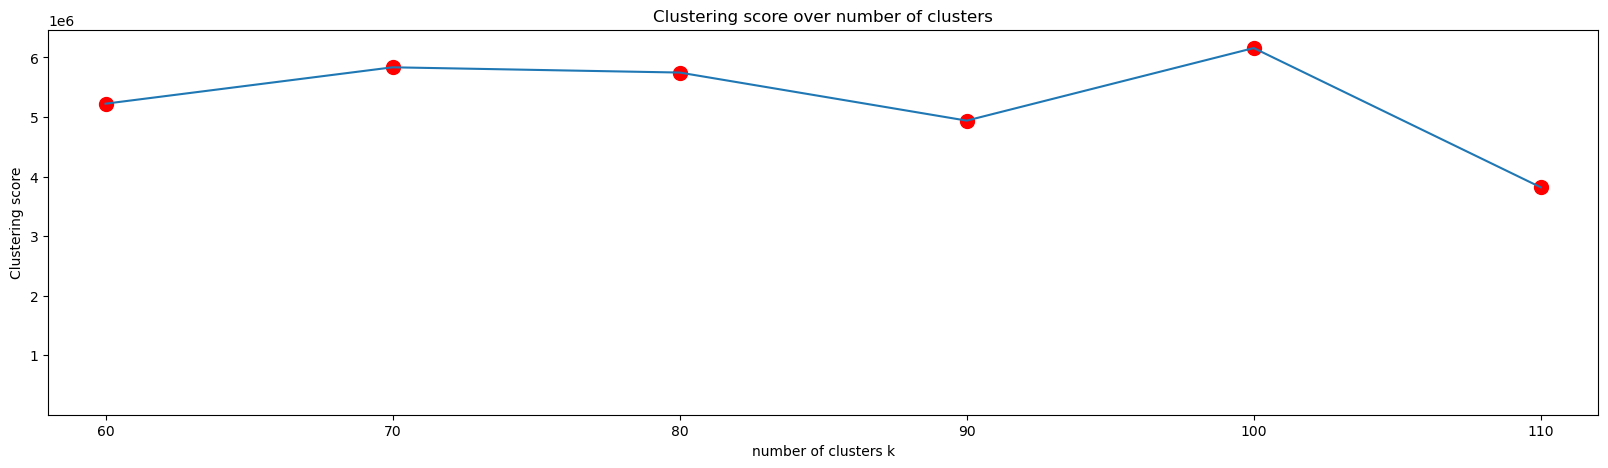

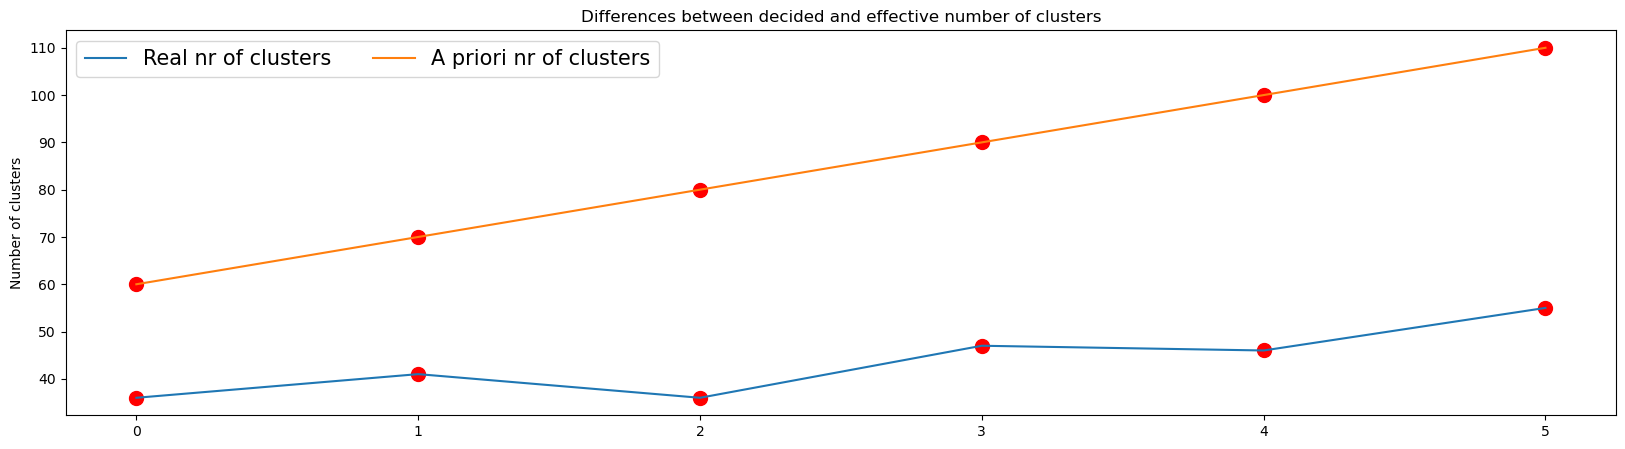

In [18]:
# plot results
plt.figure(figsize=(20,5))
_ = [_[0] for _ in scores]
plt.scatter(k_vector, _, color="r", s=100)
plt.plot(k_vector, _)
plt.axis([58,112, 0.85*np.min(scores), 1.05*np.max(scores)])
plt.xlabel("number of clusters k")
plt.ylabel("Clustering score")
plt.title("Clustering score over number of clusters")
plt.xticks(k_vector)
plt.show()

# plot results
plt.figure(figsize=(20,5))
_ = [_[1] for _ in scores]
plt.scatter(np.arange(len(k_vector)), _, c="r", s=100)
plt.scatter(np.arange(len(k_vector)), k_vector, c="r", s=100)
plt.plot(np.arange(len(k_vector)), _, label="Real nr of clusters")
plt.plot(np.arange(len(k_vector)), k_vector, label="A priori nr of clusters")
plt.ylabel("Number of clusters")
#plt.xticks(np.arange(len(k_vector)), k_vector)
plt.title("Differences between decided and effective number of clusters")
plt.legend(ncol=2, loc='upper left', frameon=True, fontsize=15)
#for i in np.arange(len(k_vector)):
#        plt.annotate(str(_[i]), i*0.98, _[i]*0.98)
#        plt.annotate(str(k_vector[i]), i*1.01, k_vector[i]*1.01)
plt.show()

<div class='alert alert-success'>
First of all, before commenting the plot, we notice one important fact:
<br>
<ul>
<li>The scale for the WSSSE dropped consistently from a magnitude of $10^{18}$ to a magnitude of $10^{7}$ 
</ul>
<br>
Other than this, we can still see the trend that increasing the number of clusters reduces the clustering score although here is much less visible since the number of clusters is really high.
<br><br>
Also, plotting the real and the expected number of clusters, we can see that the trend is always similiar and that the effective clusters are always much smaller (almost half) of the expected ones.
</div>

## Clustering using categorical features



In the previous section, we ignored the categorical features of our data: this is not a good idea, since these categorical features can be important in providing useful information for clustering.
The problem is that K-means (or at least, the one we have developed and the one we use from MLLib) only work with data points in a metric space. Informally, this means that operations such as addition, subtraction and computing the mean of data points are trivial and well defined. For a more formal definition of what a metric space is, follow this [link](https://en.wikipedia.org/wiki/Metric_space#Definition).

What we will do next is to transform each categorical feature into one or more numerical features. This approach is very widespread: imagine for example you wanted to use K-means to cluster text data. Then, the idea is to transform text data in $d$-dimensional vectors, and a nice way to do it is to use [word2vec](http://deeplearning4j.org/word2vec). If you're interested, follow this link to a nice [blog post](http://bigdatasciencebootcamp.com/posts/Part_3/clustering_news.html) on the problem.

There are two approaches:

* **Approach 1**: mapping **one** categorical feature to **one** numerical feature. The values in each categorical feature are encoded into unique numbers of the new numerical feature. For example, ['VERY HOT','HOT', 'COOL', 'COLD', 'VERY COLD'] will be encoded into [0,1,2,3,4,5]. However, by using this method, we implicit assume that the value of 'VERY HOT' is smaller than 'HOT'... This is not generally true.

* **Approach 2**: mapping **one** categorical feature to **multiple** numerical features. Basically, a single variable with $n$ observations and $d$ distinct values, to $d$ binary variables with $n$ observations each. Each observation indicating the presence (1) or absence (0) of the $d^{th}$ binary variable. For example, ['house', 'car', 'tooth', 'car'] becomes 
```
[
[1,0,0,0],
[0,1,0,0],
[0,0,1,0],
[0,0,0,1],
]
```

We call the second approach "one-hot encoding". By using this approach, we keep the same role for all values of categorical features.





<div class="alert alert-info">

Calculate the number of distinct categorical features value (at index `1,2,3`). Then construct a new input data using one-hot encoding for these categorical features (don't throw away numerical features!).

</div>

In [19]:
feat1 = raw_data.map(lambda x : x.split(",")[1]).distinct().collect()
feat2 = raw_data.map(lambda x : x.split(",")[2]).distinct().collect()
feat3 = raw_data.map(lambda x : x.split(",")[3]).distinct().collect()

In [20]:
print("feature 1: length = %d\nfeatures = \n%s\n" %(len(feat1), feat1))
print("\nfeature 2: length = %d\nfeatures = \n%s\n" %(len(feat2), feat2))
print("\nfeature 3: length = %d\nfeatures = \n%s\n" %(len(feat3), feat3))

feature 1: length = 3
features = 
['udp', 'tcp', 'icmp']


feature 2: length = 66
features = 
['ctf', 'netbios_ns', 'netbios_dgm', 'vmnet', 'bgp', 'ssh', 'whois', 'efs', 'sunrpc', 'pm_dump', 'other', 'login', 'daytime', 'nnsp', 'printer', 'uucp', 'discard', 'urp_i', 'tftp_u', 'http', 'ftp', 'ftp_data', 'http_443', 'courier', 'auth', 'IRC', 'netbios_ssn', 'Z39_50', 'domain_u', 'time', 'mtp', 'hostnames', 'X11', 'imap4', 'supdup', 'tim_i', 'smtp', 'telnet', 'eco_i', 'private', 'rje', 'gopher', 'echo', 'pop_2', 'sql_net', 'red_i', 'finger', 'ntp_u', 'remote_job', 'domain', 'nntp', 'shell', 'klogin', 'netstat', 'systat', 'uucp_path', 'urh_i', 'ecr_i', 'name', 'kshell', 'csnet_ns', 'pop_3', 'link', 'exec', 'iso_tsap', 'ldap']


feature 3: length = 11
features = 
['S2', 'REJ', 'S3', 'RSTR', 'RSTO', 'SF', 'RSTOS0', 'S0', 'SH', 'S1', 'OTH']



<div class="alert alert-success">
Let's plot the data and see how this categorical features split the data.
</div>

In [21]:
f1 = raw_data.map(lambda x : x.split(",")[1]).map(lambda x : (x, 1)).reduceByKey(add).collect()
f2 = raw_data.map(lambda x : x.split(",")[2]).map(lambda x : (x, 1)).reduceByKey(add).collect()
f3 = raw_data.map(lambda x : x.split(",")[3]).map(lambda x : (x, 1)).reduceByKey(add).collect()

f1.sort(key=lambda x : x[1], reverse=True)
f2.sort(key=lambda x : x[1], reverse=True)
f3.sort(key=lambda x : x[1], reverse=True)

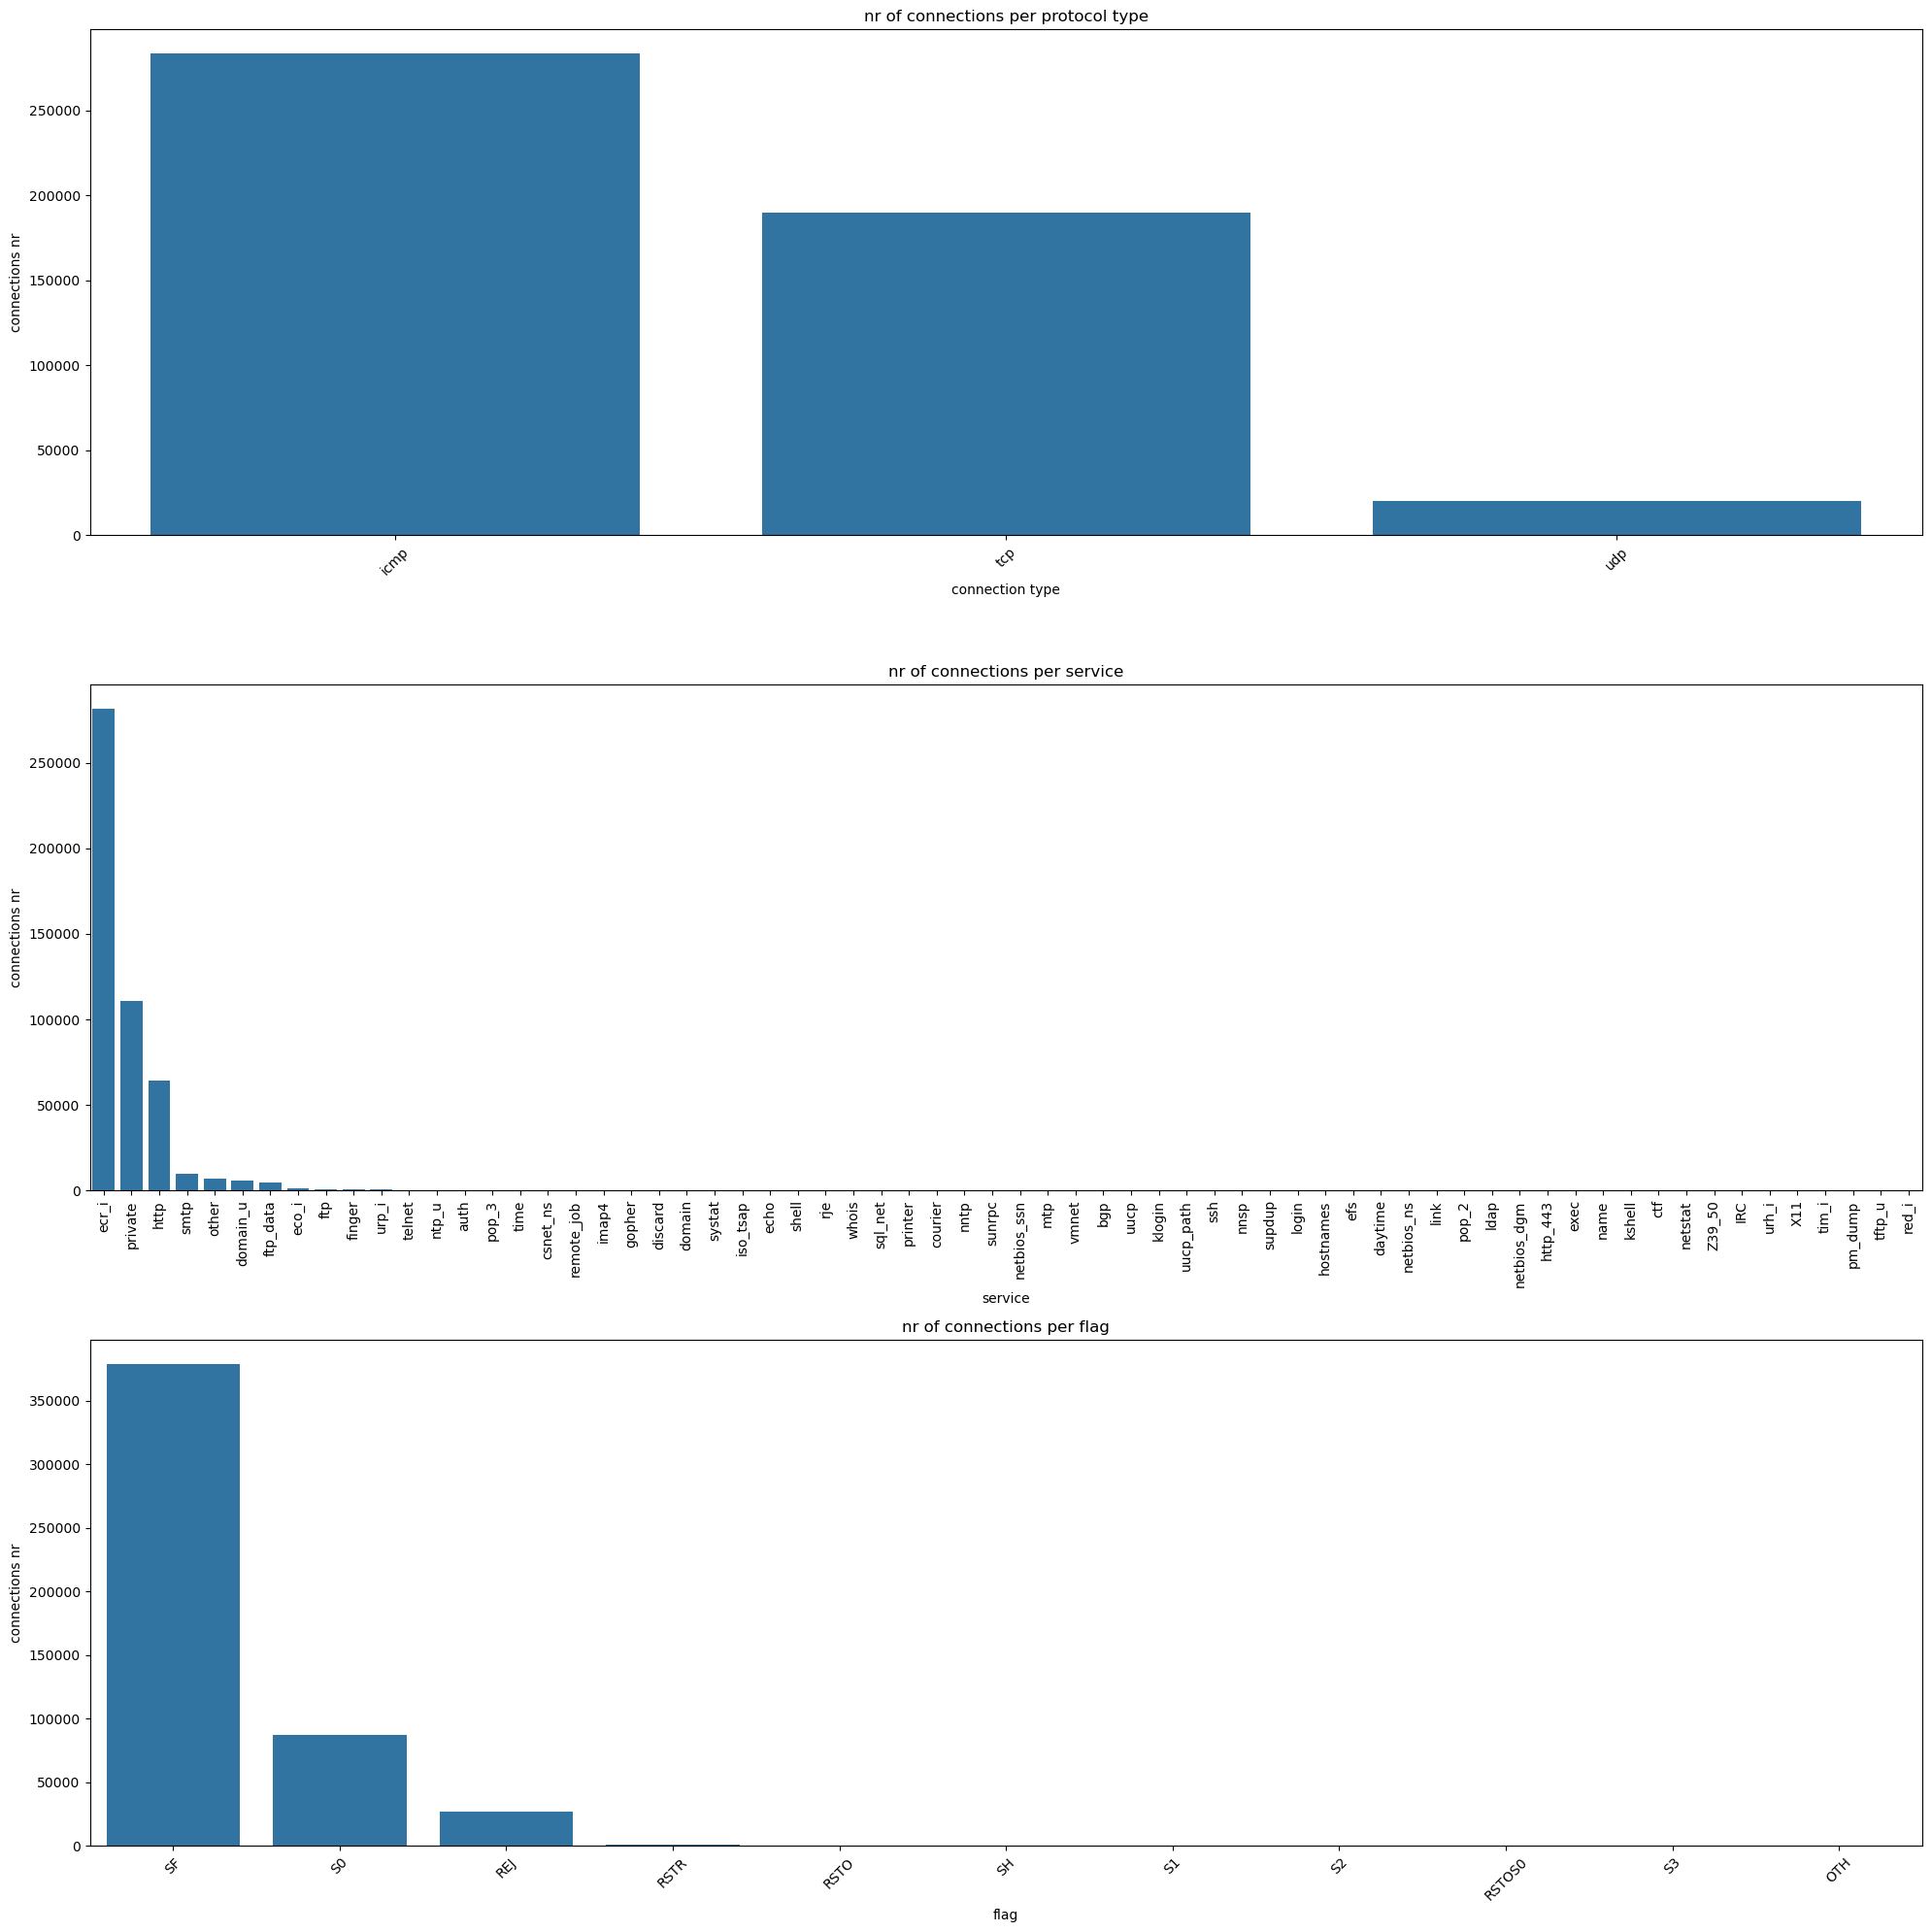

In [22]:
#plotting
a = plt.figure(figsize=(20,20))
plt.subplot(311)
sns.barplot(x=np.arange(len(f1)), y=[_[1] for _ in f1])
plt.xticks(np.arange(len(f1)), [_[0] for _ in f1], rotation=45)
plt.title("nr of connections per protocol type")
plt.xlabel("connection type")
plt.ylabel("connections nr")

plt.subplot(312)
sns.barplot(x=np.arange(len(f2)), y=[_[1] for _ in f2])
plt.xticks(np.arange(len(f2)), [_[0] for _ in f2], rotation="vertical")
plt.title("nr of connections per service")
plt.xlabel("service")
plt.ylabel("connections nr")

plt.subplot(313)
sns.barplot(x=np.arange(len(f3)), y=[_[1] for _ in f3])
plt.xticks(np.arange(len(f3)), [_[0] for _ in f3], rotation=45)
plt.title("nr of connections per flag")
plt.xlabel("flag")
plt.ylabel("connections nr")

plt.tight_layout()

plt.show()

<div class="alert alert-success">
We are trying to take account of all the different attributes we have at our disposal. Initially we didn't care about the categorical attributes (index 1,2,3) but now, with Hot Encoding, we are trying to see if the clustering with also this attributes becomes better.
<br><br>
Before using this new, more complete, data, let's see how this features separate our data set of nearly 5 million elements.
<br><br>
The first attribute describes the connection type and can take 3 values, tcp, udp and icmp. The data is almost equally divided between icmp and tcp, leaving less than 50 thousand connections to udp.
<br><br>
The second attribute describes the service and the third attribute describes the flags. As we can see, unfortunately, both this attributes concentrate much of the data in just 3 or 4 labels out of the 70, for the second attribute, and 11, for the third attribute.
<br><br>
We wrote <i>unfortunately</i> because having a not-so-distributed division of the data make us think that the clustering will not improve that much leaving the data as packed as before.
</div>

In [23]:
def parseLineWithHotEncoding(line):
    cols = line.split(",")
    # label is the last column
    label = cols[-1]
    
    vector = cols[0:-1]
    
    # the binary features that are encoded from the first categorical feature
    featureOfCol1 = [0]*len(feat1)
    featureOfCol1[feat1.index(vector[1])] = 1
    # the binary features that are encoded from the second categorical feature
    featureOfCol2 = [0]*len(feat2)
    featureOfCol2[feat2.index(vector[2])] = 1
    # the binary features that are encoded from the third categorical feature
    featureOfCol3 = [0]*len(feat3)
    featureOfCol3[feat3.index(vector[3])] = 1
    
    # construct the new vector
    vector = ([vector[0]] + featureOfCol1 + featureOfCol2 + 
        featureOfCol3 + vector[4:])
    
    # convert each value from string to float
    vector = np.array(vector, dtype=np.float)
    
    return (label, vector)

labelsAndData = raw_data.map(parseLineWithHotEncoding)

# we only need the data, not the label
#data = labelsAndData.values().cache()

#with our normalizeData function, we can simply do:
labelsAndDataNorm = normalizeData(labelsAndData).cache()
normalizedData = labelsAndDataNorm.map(lambda x:x[1]).cache()

/var/folders/yf/tn88zczj6719nsbh9hywpw440000gn/T/ipykernel_36783/1404170828.py:23: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/var/folders/yf/tn88zczj6719nsbh9hywpw440000gn/T/ipykernel_36783/1404170828.py:23: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/var/folders/yf/tn88zczj6719nsbh9hywpw440000gn/T/ipykernel_36783/1404170828.py:23: Dep

<div class="alert alert-warning">
<h3>K Means Clustering</h3>
</div>


<div class="alert alert-info">

Using the new data, cluster the connections with different values of $k \in [80,90,100,110,120,130,140,150,160]$.
Evaluate the results and choose the best value of $k$ as previous questions.

</div>

In [24]:
k_vector = [20,30,40,50,60,70,80,90,100,110,120,130,140,150,160]
scores = [clusteringScore(normalizedData, k, withCenters=True) for k in k_vector]
for i, score in enumerate(scores):
    print("k = %3d, (effective nr. of clusters = %3d) WSSSE = %d" %(k_vector[i], score[1], score[0]))

/var/folders/yf/tn88zczj6719nsbh9hywpw440000gn/T/ipykernel_36783/1404170828.py:23: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/var/folders/yf/tn88zczj6719nsbh9hywpw440000gn/T/ipykernel_36783/1404170828.py:23: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/var/folders/yf/tn88zczj6719nsbh9hywpw440000gn/T/ipykernel_36783/1404170828.py:23: Dep

k =  20, (effective nr. of clusters =  15) WSSSE = 40396413
k =  30, (effective nr. of clusters =  18) WSSSE = 39571170
k =  40, (effective nr. of clusters =  18) WSSSE = 39487137
k =  50, (effective nr. of clusters =  24) WSSSE = 37019618
k =  60, (effective nr. of clusters =  28) WSSSE = 35783320
k =  70, (effective nr. of clusters =  36) WSSSE = 33068852
k =  80, (effective nr. of clusters =  37) WSSSE = 32112306
k =  90, (effective nr. of clusters =  48) WSSSE = 30300797
k = 100, (effective nr. of clusters =  47) WSSSE = 31086071
k = 110, (effective nr. of clusters =  63) WSSSE = 26845407
k = 120, (effective nr. of clusters =  55) WSSSE = 27797841
k = 130, (effective nr. of clusters =  59) WSSSE = 29238863
k = 140, (effective nr. of clusters =  68) WSSSE = 27692721
k = 150, (effective nr. of clusters =  81) WSSSE = 25052238
k = 160, (effective nr. of clusters =  81) WSSSE = 24594456


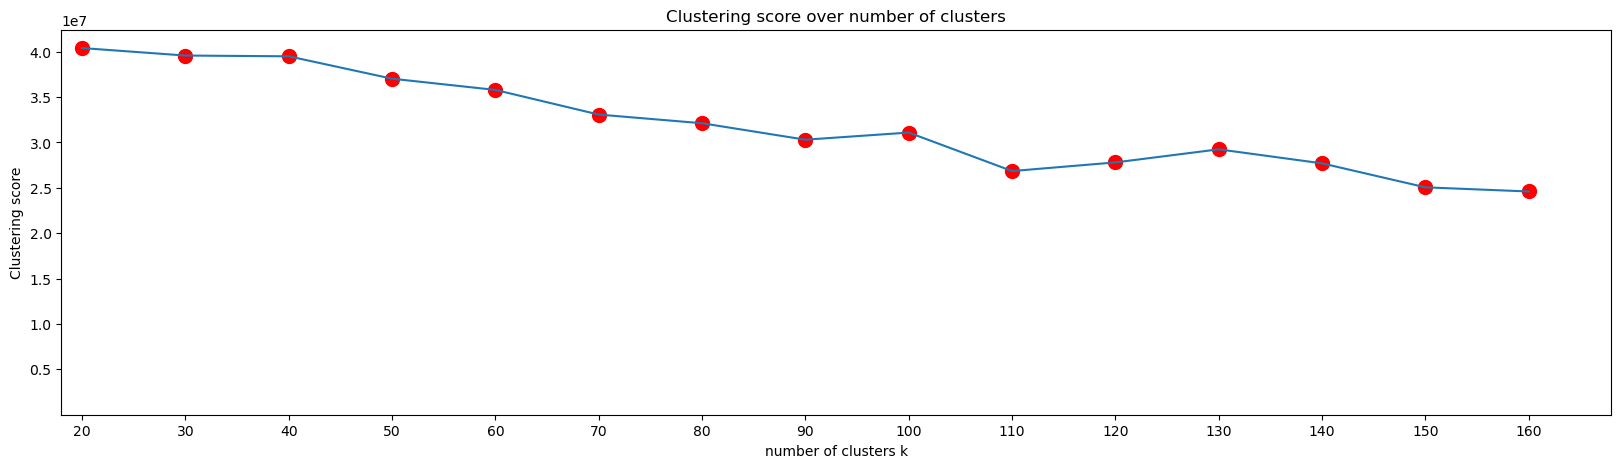

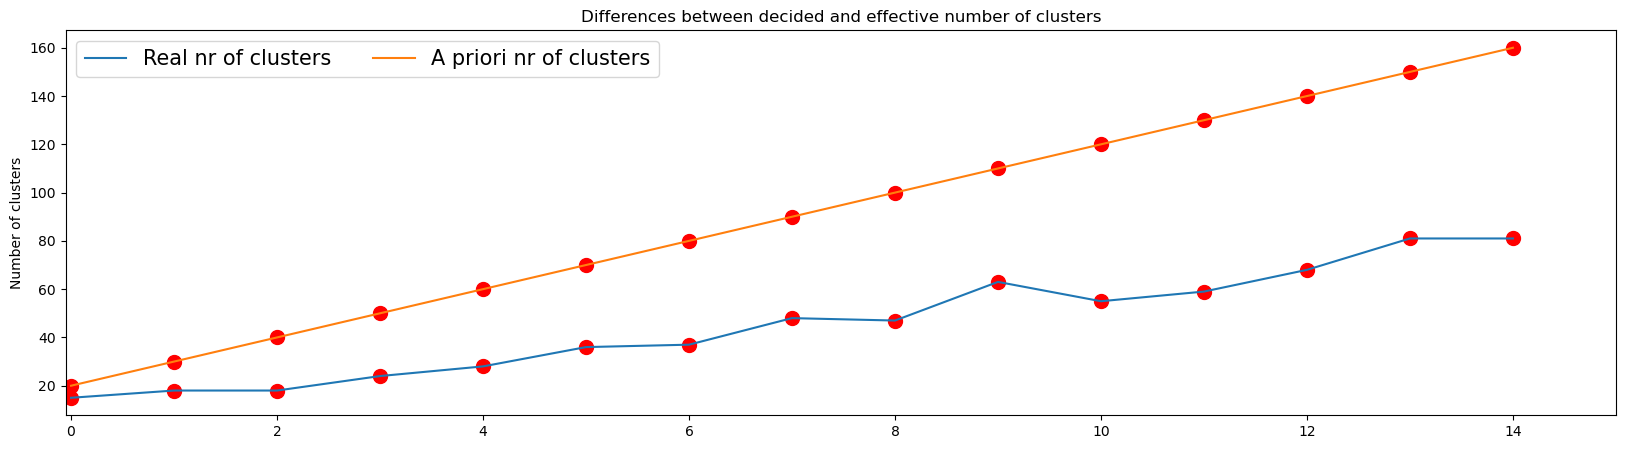

In [25]:
# plot results
plt.figure(figsize=(20,5))
_ = [_[0] for _ in scores]
plt.scatter(k_vector, _, color="r", s=100)
plt.plot(k_vector, _)
plt.axis([18, 1.05*np.max(k_vector), 0.85*np.min(scores), 1.05*np.max(scores)])
plt.xlabel("number of clusters k")
plt.ylabel("Clustering score")
plt.title("Clustering score over number of clusters")
plt.xticks(k_vector)
plt.show()

# plot results
plt.figure(figsize=(20,5))
_ = [_[1] for _ in scores]
plt.scatter(np.arange(len(k_vector)), _, c="r", s=100)
plt.scatter(np.arange(len(k_vector)), k_vector, c="r", s=100)
plt.plot(np.arange(len(k_vector)), _, label="Real nr of clusters")
plt.plot(np.arange(len(k_vector)), k_vector, label="A priori nr of clusters")
plt.ylabel("Number of clusters")
plt.xlim([-0.05, np.max(len(k_vector))])
#plt.xticks(np.arange(len(k_vector)), k_vector)
plt.title("Differences between decided and effective number of clusters")
plt.legend(ncol=2, loc='upper left', frameon=True, fontsize=15)
#for i in np.arange(len(k_vector)):
#        plt.annotate(str(_[i]), i*0.98, _[i]*0.98)
#        plt.annotate(str(k_vector[i]), i*1.01, k_vector[i]*1.01)
plt.show()

<div class="alert alert-success">
In our opinion, checking the clsutering score for just clusters with 80+ clusters up to 160 didn't make a lot of sense. We want to see also how it performs with a smaller $k$, but still enough large to contain all the possible labels. This is why we increased the <code>k_vector</code> from 20 up to 160.
<br><br>
As before, we plotted both the trend of the clustering score and the relationship between effective and desired number of clusters.
<br><br>
As we can see, the clustering score improves as $k$ increases, but remains almost the same from k=100 onwards.
<br>
We can also see a first "bump" when $k$ increases from 80 to 90 that is the best improvement we were able to get from one hop to the next one.
<br><br>
We'll try to perform the next tests, anomaly detection and silhouette with $k$ = 90, a good compromise between number of clusters and <code>clusteringScore</code>.
</div>

## Anomaly detection
When we have a new connection data (e.g., one that we never saw before), we simply find the closest cluster for it, and use this information as a proxy to indicate whether the data point is anomalous or not. A simple approach to decide when there is an anomaly or not, amounts to measuring the new data point’s distance to its nearest centroid. If this distance exceeds some thresholds, it is anomalous.


<div class="alert alert-info">

Build your model with the best value of $k$ in your opinion. Then, detect the anomalous connections in our data. Plot and discuss your result.

</div>

<div class="label label-success">HINT</div> The threshold has strong impact on the result. Be careful when choosing it! A simple way to choose the threshold's value is picking up a distance of a data point from among known data. For example, the 100th-farthest data point distance can be an option.

In [26]:
bestK = 90

In [27]:
clusters = KMeans.train(normalizedData, bestK, maxIterations=10, initializationMode="random")

24/01/12 12:11:12 WARN MemoryStore: Not enough space to cache rdd_1085_10 in memory! (computed 12.6 MiB so far)
24/01/12 12:11:12 WARN BlockManager: Persisting block rdd_1085_10 to disk instead.
24/01/12 12:11:12 WARN MemoryStore: Not enough space to cache rdd_1085_11 in memory! (computed 12.6 MiB so far)
24/01/12 12:11:12 WARN BlockManager: Persisting block rdd_1085_11 to disk instead.
24/01/12 12:11:12 WARN MemoryStore: Not enough space to cache rdd_1085_8 in memory! (computed 12.6 MiB so far)
24/01/12 12:11:12 WARN BlockManager: Persisting block rdd_1085_8 to disk instead.
24/01/12 12:11:12 WARN MemoryStore: Not enough space to cache rdd_1085_9 in memory! (computed 12.6 MiB so far)
24/01/12 12:11:12 WARN BlockManager: Persisting block rdd_1085_9 to disk instead.
24/01/12 12:11:13 WARN MemoryStore: Not enough space to cache rdd_1085_9 in memory! (computed 12.6 MiB so far)
24/01/12 12:11:13 WARN MemoryStore: Not enough space to cache rdd_1085_9 in memory! (computed 1025.2 KiB so far)


In [28]:
print("Initial k clusters:", bestK)
print("Effective clusters:", len(clusters.centers))

Initial k clusters: 90
Effective clusters: 48


<div class="alert alert-success">
Even here we can see that even though we start with 120 clusters, the model degenerates to only 68 clusters since some of them remain with 0 elements.
</div>

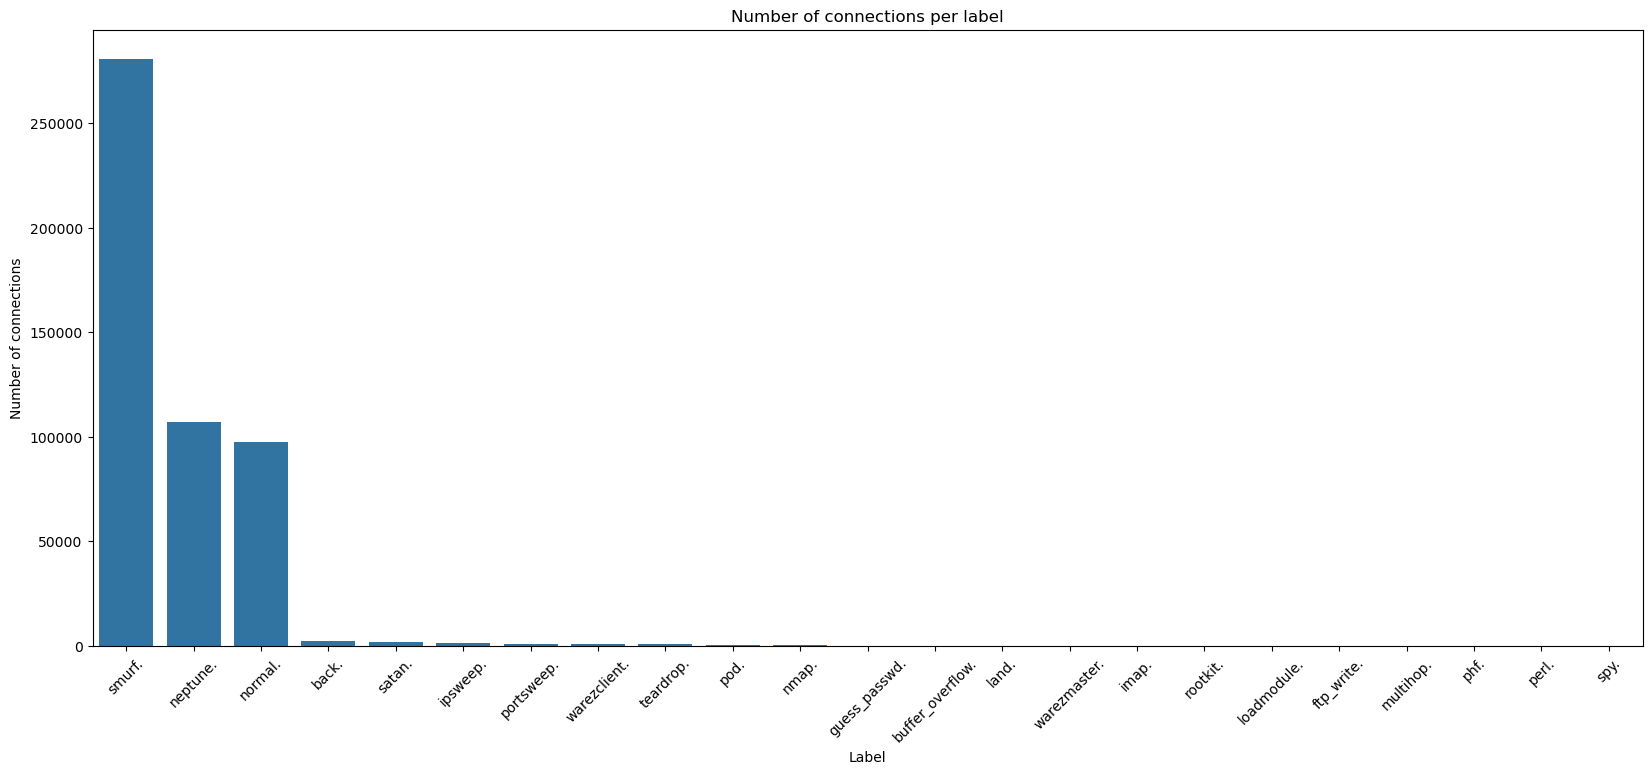

In [29]:
y.sort(key=lambda x : x[1], reverse=True)
plt.figure(figsize=(20,8))
sns.barplot(x=np.arange(len(y)), y=[_[1] for _ in y])
plt.xticks(np.arange(len(y)), [_[0] for _ in y], rotation=45)
plt.xlabel("Label")
plt.ylabel("Number of connections")
plt.title("Number of connections per label")
plt.show()

<div class="alert alert-success">
In the plot above, we chose as a threshold 5000 to plot the labels of the 2857 anomalous connections we would detect.
<br><br>
It's interesting to see that of the almost 3 thousand anomalous connections, almost 2500 are labelled as normal.
<br><br>
Actually, we expected a result similiar to this one. <b><i>Why?</i></b> Because all the other labels are <i>known</i> attacks and in our opinion an anomaly is a connection different to all the other ones already seen like, for example, a new type of attack, an unknown error, a strange traffic... In our opinion, a <code>guess_passwd</code> attack or a <code>buffer_overflow</code> attack is known and traffic analyst know how to recognize it instead, a model like this one should be used to allow them to recognize <i>new</i> type of dangers. And this is why, since this should be <i>unknown</i> dangers that the system doesn't know how to label, in our opinion are all labelled as <code>normal</code> connection.
<br><br>
In our opinion a model like this one would be used in parallel with another model able to predict which type of connections are happening; let's say a decision tree that uses all the attributes to label the connections and recognize known attacks, and this model here to recognize new attacks and strange traffics.
<br><br>
Let's try to increase the threshold to see if, even with a smaller number of anomalous connections detected, the <code>normal</code> label would be the major one.
</div>

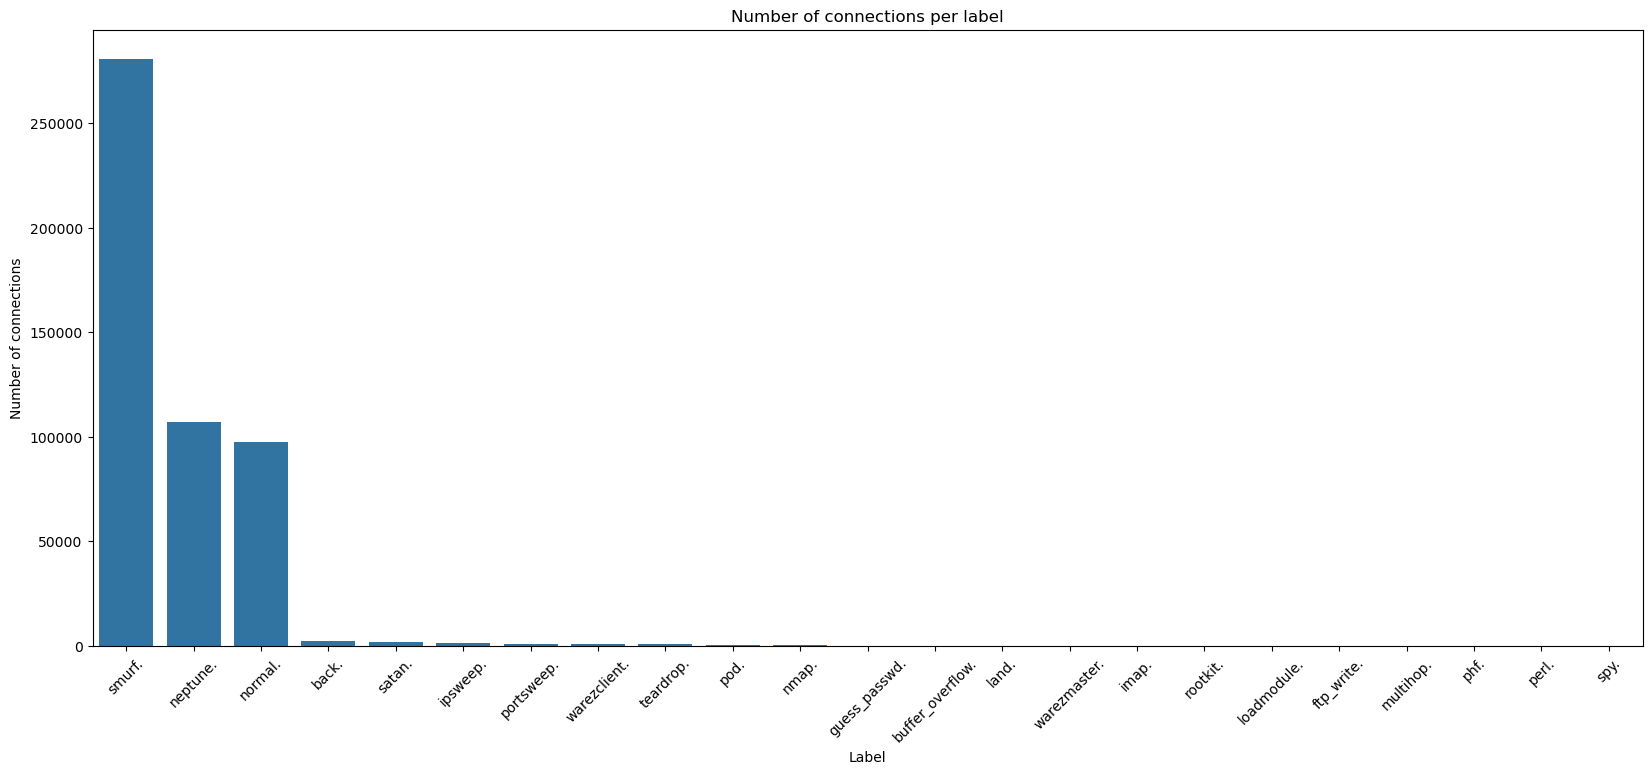

In [30]:
y.sort(key=lambda x : x[1], reverse=True)
plt.figure(figsize=(20,8))
sns.barplot(x=np.arange(len(y)), y=[_[1] for _ in y])
plt.xticks(np.arange(len(y)), [_[0] for _ in y], rotation=45)
plt.xlabel("Label")
plt.ylabel("Number of connections")
plt.title("Number of connections per label")
plt.show()

<div class="alert alert-success">
We increased the threshold up to a point where only 131 anomalies would be detected.
<br><br>
As we can see, the <code>normal</code> label is still the most present one, giving a hint that our reasoning in the comment before might be correct.
</div>

<div class="alert alert-success">

To predict a cluster for a point, it is sufficient to run <code>find_closest_centroid</code> with parameters the point itself and the array of the centroids which will return the index of the closest centroid.
</div>